# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu124
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? NVIDIA GeForce RTX 3090
Total GPU memory 25.41 GB. Free GPU memory 24.97 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

We analyse the data to check the number of samples and their size.

In [5]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. 

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        self.layers = []
        self.output_size = output_size
        self.input_size = input_size

        self.layers .append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers .append(nn.ReLU())

        for i in range(1, len(hidden_sizes)):
            self.layers .append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers .append(nn.ReLU())

        self.layers .append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers .append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*self.layers )

    def forward(self, x):
        X = x.flatten(start_dim=1)
        output = self.model(X)
        return output

**Question**: Create one of the model proposed in the article.

In [13]:
input_size = image_size[0]*image_size[1]
hidden_sizes = [10,10,10]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [14]:
def training(model, train_loader, optimizer, num_epochs, loss_model, verbose = True):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose : 
          if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [15]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [16]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 2.1055
Epoch [1/5], Step [200/235], Loss: 1.8367
Epoch [2/5], Step [100/235], Loss: 1.7941
Epoch [2/5], Step [200/235], Loss: 1.7818
Epoch [3/5], Step [100/235], Loss: 1.8218
Epoch [3/5], Step [200/235], Loss: 1.8037
Epoch [4/5], Step [100/235], Loss: 1.7847
Epoch [4/5], Step [200/235], Loss: 1.8512
Epoch [5/5], Step [100/235], Loss: 1.7643
Epoch [5/5], Step [200/235], Loss: 1.7809


In [17]:
evaluation(model, test_loader)

Accuracy of test images: 70.020000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

In [12]:
hidden_sizes =[100,150]

model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training(model, train_loader, optimizer, num_epochs, loss_model)
evaluation(model, test_loader)

Epoch [1/5], Step [100/235], Loss: 1.6757
Epoch [1/5], Step [200/235], Loss: 1.5739
Epoch [2/5], Step [100/235], Loss: 1.5427
Epoch [2/5], Step [200/235], Loss: 1.5477
Epoch [3/5], Step [100/235], Loss: 1.5637
Epoch [3/5], Step [200/235], Loss: 1.5477
Epoch [4/5], Step [100/235], Loss: 1.5324
Epoch [4/5], Step [200/235], Loss: 1.5027
Epoch [5/5], Step [100/235], Loss: 1.5065
Epoch [5/5], Step [200/235], Loss: 1.5148
Accuracy of test images: 95.220000 %


In [23]:
hidden_sizes =[300,70]
num_epochs_test = 10

model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training(model, train_loader, optimizer, num_epochs_test, loss_model)
evaluation(model, test_loader)

Epoch [1/10], Step [100/235], Loss: 1.5611
Epoch [1/10], Step [200/235], Loss: 1.5429
Epoch [2/10], Step [100/235], Loss: 1.5339
Epoch [2/10], Step [200/235], Loss: 1.5393
Epoch [3/10], Step [100/235], Loss: 1.5023
Epoch [3/10], Step [200/235], Loss: 1.5239
Epoch [4/10], Step [100/235], Loss: 1.5139
Epoch [4/10], Step [200/235], Loss: 1.5056
Epoch [5/10], Step [100/235], Loss: 1.4933
Epoch [5/10], Step [200/235], Loss: 1.4991
Epoch [6/10], Step [100/235], Loss: 1.5081
Epoch [6/10], Step [200/235], Loss: 1.5036
Epoch [7/10], Step [100/235], Loss: 1.4907
Epoch [7/10], Step [200/235], Loss: 1.4828
Epoch [8/10], Step [100/235], Loss: 1.4869
Epoch [8/10], Step [200/235], Loss: 1.4909
Epoch [9/10], Step [100/235], Loss: 1.4810
Epoch [9/10], Step [200/235], Loss: 1.4873
Epoch [10/10], Step [100/235], Loss: 1.4761
Epoch [10/10], Step [200/235], Loss: 1.4767
Accuracy of test images: 97.220000 %


**Answer :**

With the initial architecture 3 hidden layers of size 10 we see that the performance is quiet low. I chose the architecture and the hyperparamters above (2 hidden layers of 300 and 70 neuronnes) to improve performance for the following reasons : I simply preferred to increase the layer size rather than the number of layers, because the data that we want to classifi is not very complexe. In fact, a number is just composed by some basic lines, so few layers are required to represent the data. Also, we know that there is the vanishing gradient issue when we have too much layers.

Also i increase the number of epoch to have a better training.

**By following this reasonning we reach an accuracy of 97.22 %**

-----------
-----------

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [37]:
# Parameters adversarial example
index=125 # index test image to use

max_iter_search=3000
initial_c = 0.000001  # Initial value of c
max_c = 0.1  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

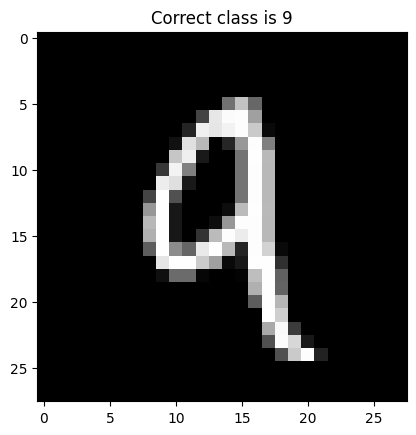

In [38]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [39]:
def plot_results(X, r, Xr, Y, l, fail=True):

    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 9, the new class will be 2
Iter 20/3000, Value of c: 0.000001
Iter 40/3000, Value of c: 0.000002
Iter 60/3000, Value of c: 0.000003
Iter 80/3000, Value of c: 0.000005
Iter 100/3000, Value of c: 0.000007
Found c = 0.000008 satisfying f(x + r) = l
Optimization succeeded with c = 0.000008 in 104 iterations
Norm Perturbation |r|: 19.534038543701172


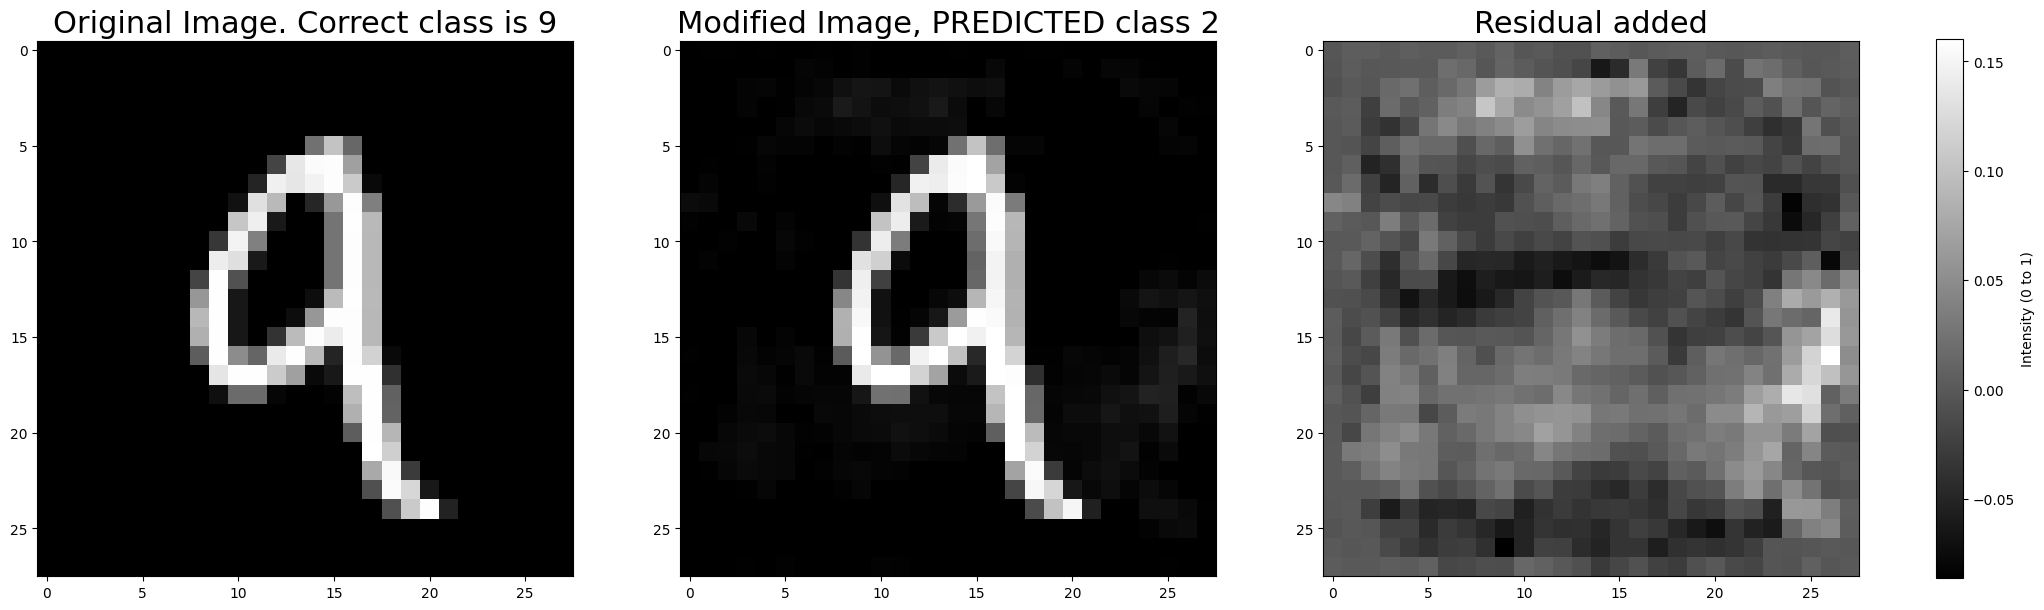

In [43]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-7 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = c * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r])

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    # If not satisfied, increase c
    c = c * 1.02 # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?


______
------
**ANSWER** : 

The algorithm doesn't always converge. For example, it failed for class 666 but worked for index 125 (a number 9). If the regularization coefficient c is too high (~ e10-3), the reclassification works, but the image loses its visual similarity to the original and becomes unrecognizable. If c is too low (for instance e10-5 in some example) and the target class is semanticly far from the original class, reclassification fails, requiring a higher c and resulting in abrupt changes. When c is correctly matched, the target class is successfully predicted and the image retains its resemblance to the original. The effectiveness of convergence depends on the semantic similarity between the initial class and the target class.

To conclude, if the regularization coefficient is too high, the image will be reclassified to the target label, but the visual aspect of the image will not be preserved, and the image will no longer be of interest as it no longer represents anything. The average distortion depend on how far the semantic represnetation of each number is from the other one

-------
-------

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

In [44]:
# MODELS TO BE TESTED : 
hidden_sizes =[200]
model_200 = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model_200.parameters(), lr=learning_rate, weight_decay=weight_decay)
training(model_200, train_loader, optimizer, num_epochs, loss_model,verbose=False)

hidden_sizes =[150,150]
model_2_150 = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model_2_150.parameters(), lr=learning_rate, weight_decay=weight_decay)
training(model_2_150, train_loader, optimizer, num_epochs, loss_model, verbose=False)


In [45]:
def product_adversarial_instance(model, model2, verbose = False) : 

    dict_result = {}

    for i in range(10): 
        sucess = False
        r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
        label= testY - i # manually chosen target class label different from true one
        l = torch.tensor([label]).to(device)  
        l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
        print(f"The true class is {testY}, the new class will be {l[0]}")


        # Define the loss function
        def objective(c, r, x, l):
            term1 = c * torch.norm(r)
            term2 = loss_model(model(x+r), l)
            return term1 + term2


        # Line search to find the minimum c > 0
        c = initial_c
        iter=0
        while (c <= max_c) and (iter <= max_iter_search):    
            # Define the optimizer (Box-Constrained L-BFGS)
            optimizerLBFGS = optim.LBFGS([r])

            def closure():
                optimizerLBFGS.zero_grad()
                loss = objective(c, r, testI, l)
                loss.backward()
                return loss

            # Perform optimization
            optimizerLBFGS.step(closure)


            # Evaluate the condition f(x + r) = l
            with torch.no_grad():
                x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
                pred = model(x_r)
                predicted_label = torch.argmax(pred, dim=1)

            # Check if the condition f(x + r) = l is satisfied
            if predicted_label == l:
                print(f"Found c = {c:.6f} satisfying f(x + r) = l")
                iter=iter+1
                break
            else:
                iter=iter+1

            # If not satisfied, increase c
            c = c + 0.00001 # Adjust step size for line search
            if verbose : 
                if (iter) % 20 == 0:
                    print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

        if (c > max_c) or (iter > max_iter_search):
            print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
            #print(f"Perturbation r: {r}")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

            plot_results(testI, r, x_r, testY, l, fail=True)

        else:
            print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
            #print(f"Perturbation r: {r}")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
            succes = True
            plot_results(testI, r, x_r, testY, l, fail=False)
        
        dict_result[i] = {'c' : c,
                          'norm_r' : torch.norm(r, p=1), 
                          'succes' : succes}

        print("\nTesting adversarial example on other model...")
        model2.to(device)
        model2.eval()

        with torch.no_grad():
            pred = model2(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        if predicted_label != l:
            print ("#######################################################")
            print(f"Adversarial example misclassified by other model as class {predicted_label.item()} instead of {l}.")
            print ("#######################################################")

        else:
            print(f"Adversarial example correctly classified by the other model")


The true class is 9, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 12.463590621948242


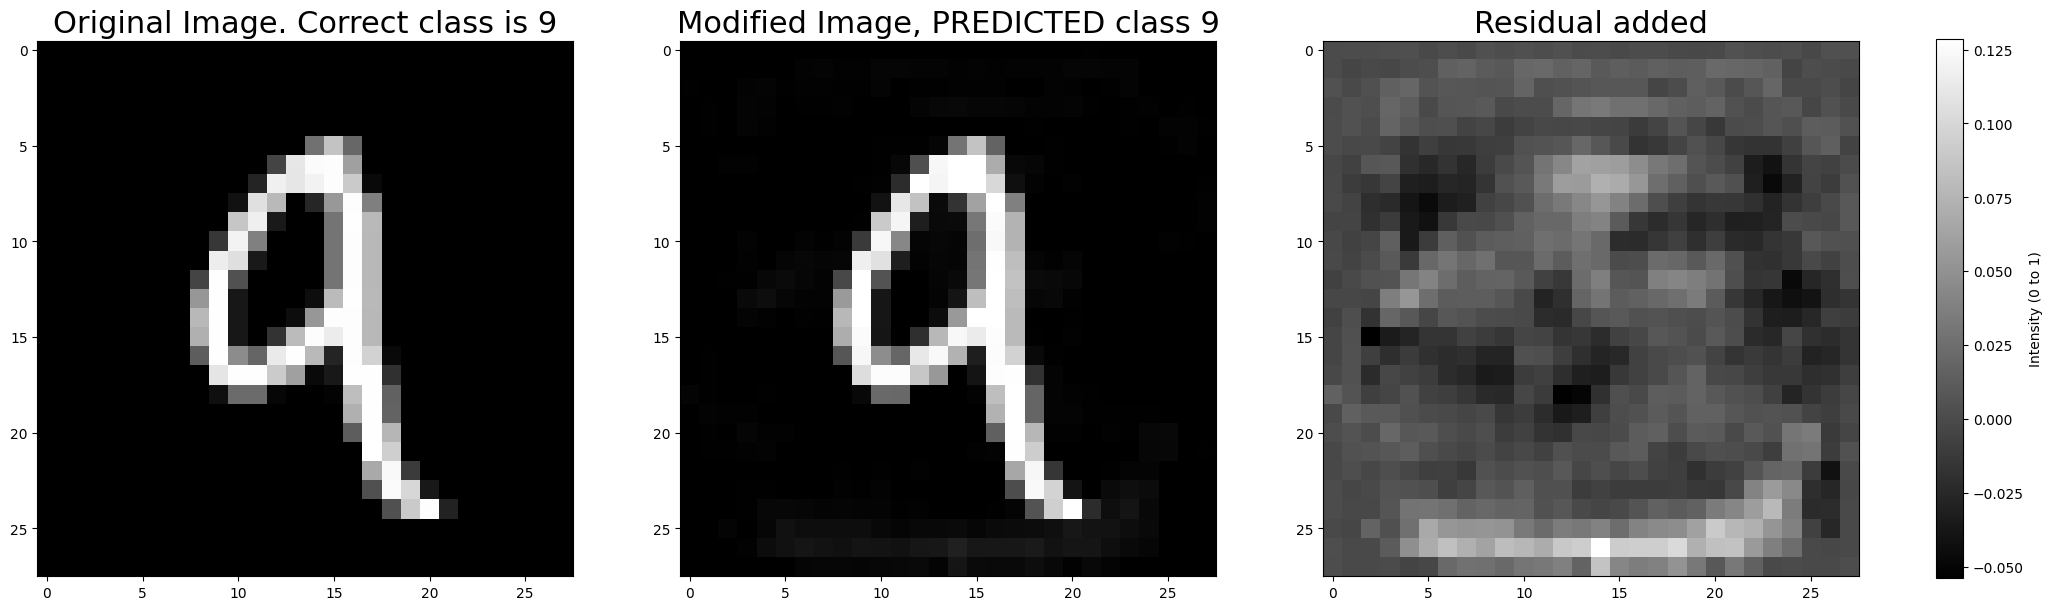


Testing adversarial example on other model...
Adversarial example correctly classified by the other model
The true class is 9, the new class will be 8
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 1.1341387536279798e+18


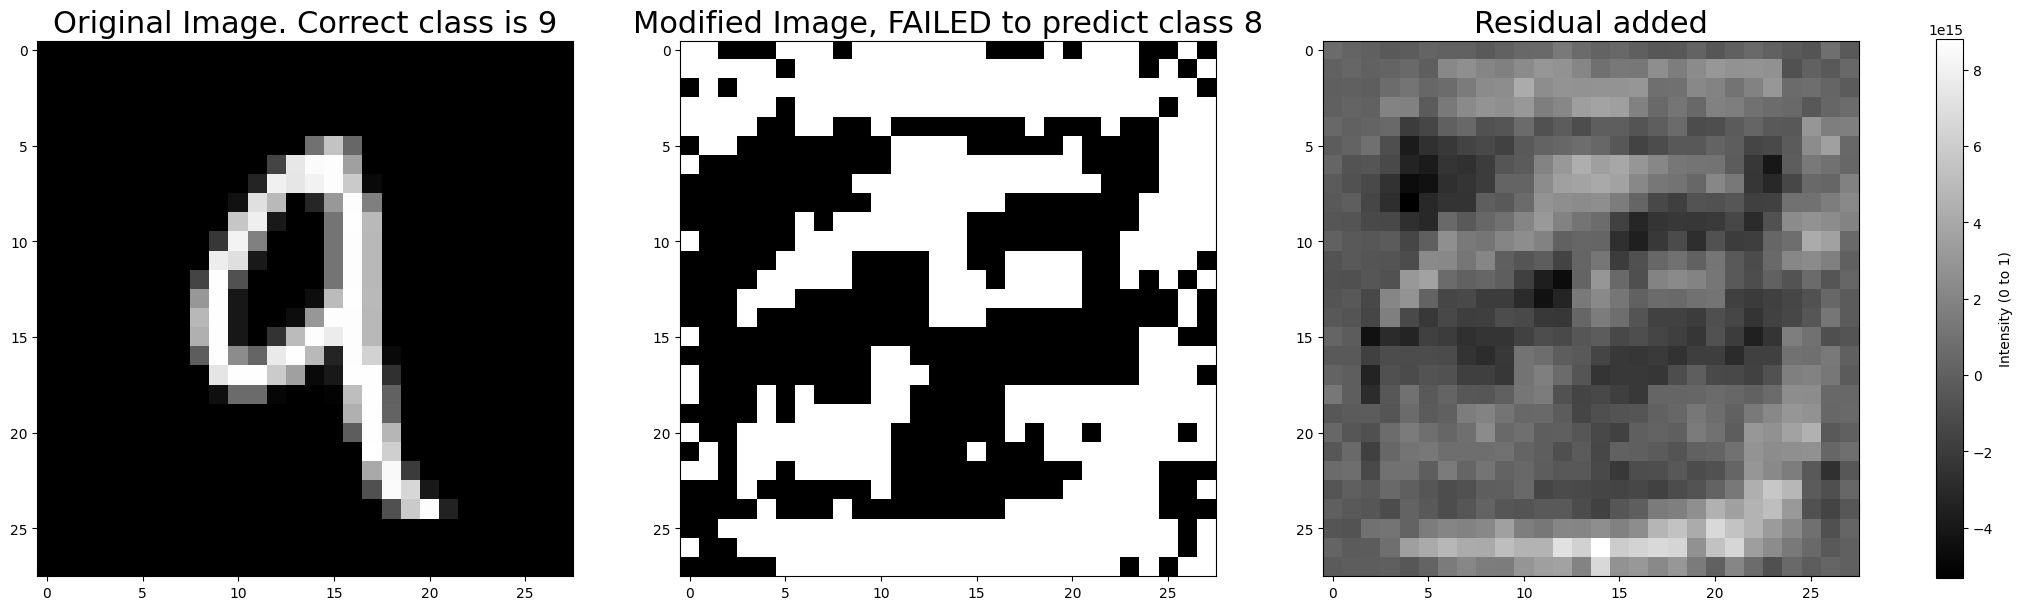


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 5 instead of tensor([8], device='cuda:0').
#######################################################
The true class is 9, the new class will be 7
Found c = 0.000031 satisfying f(x + r) = l
Optimization succeeded with c = 0.000031 in 4 iterations
Norm Perturbation |r|: 4420124.5


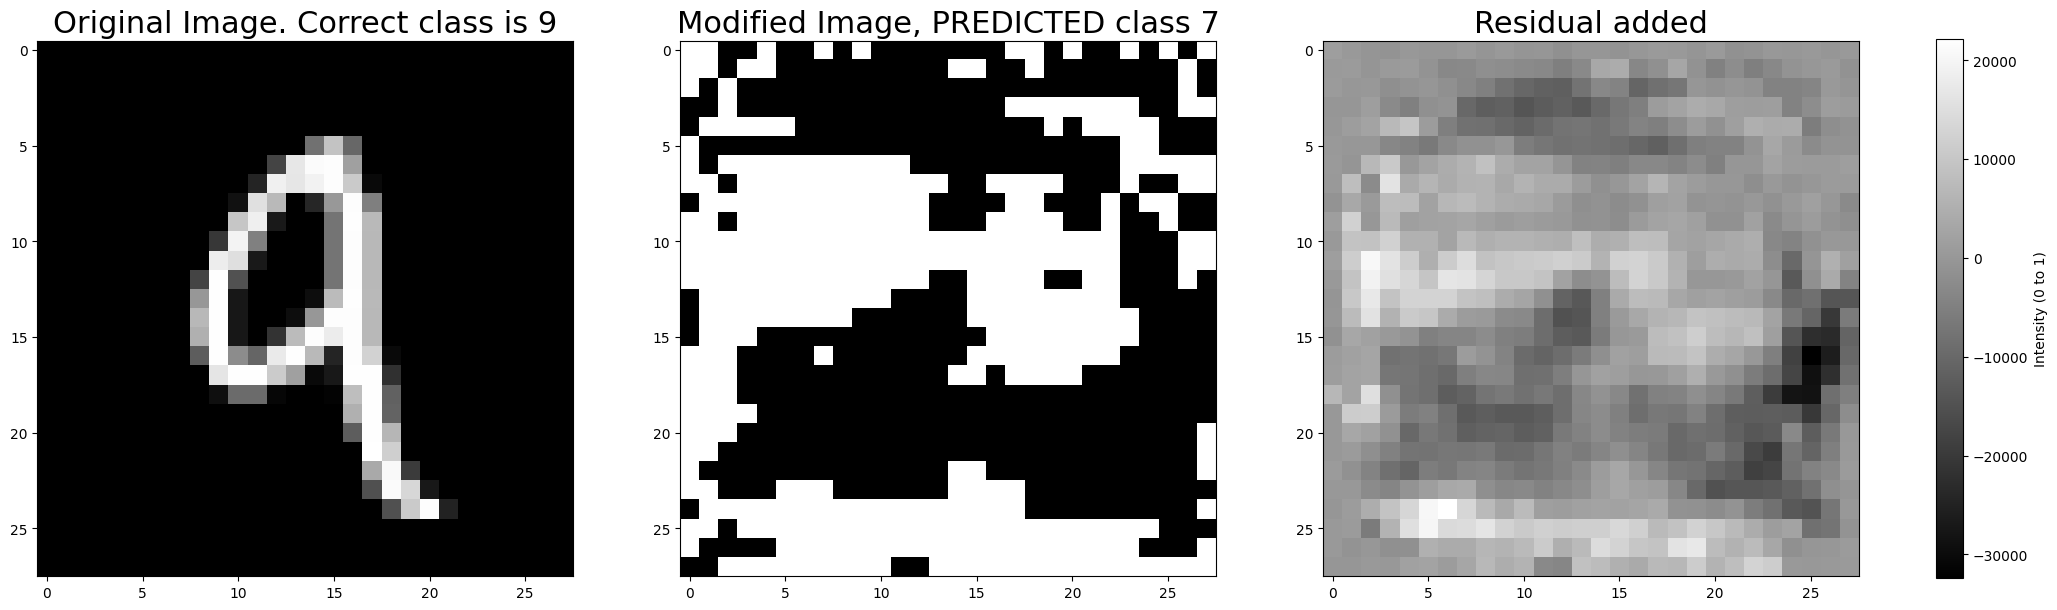


Testing adversarial example on other model...
Adversarial example correctly classified by the other model
The true class is 9, the new class will be 6
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 292506763264.0


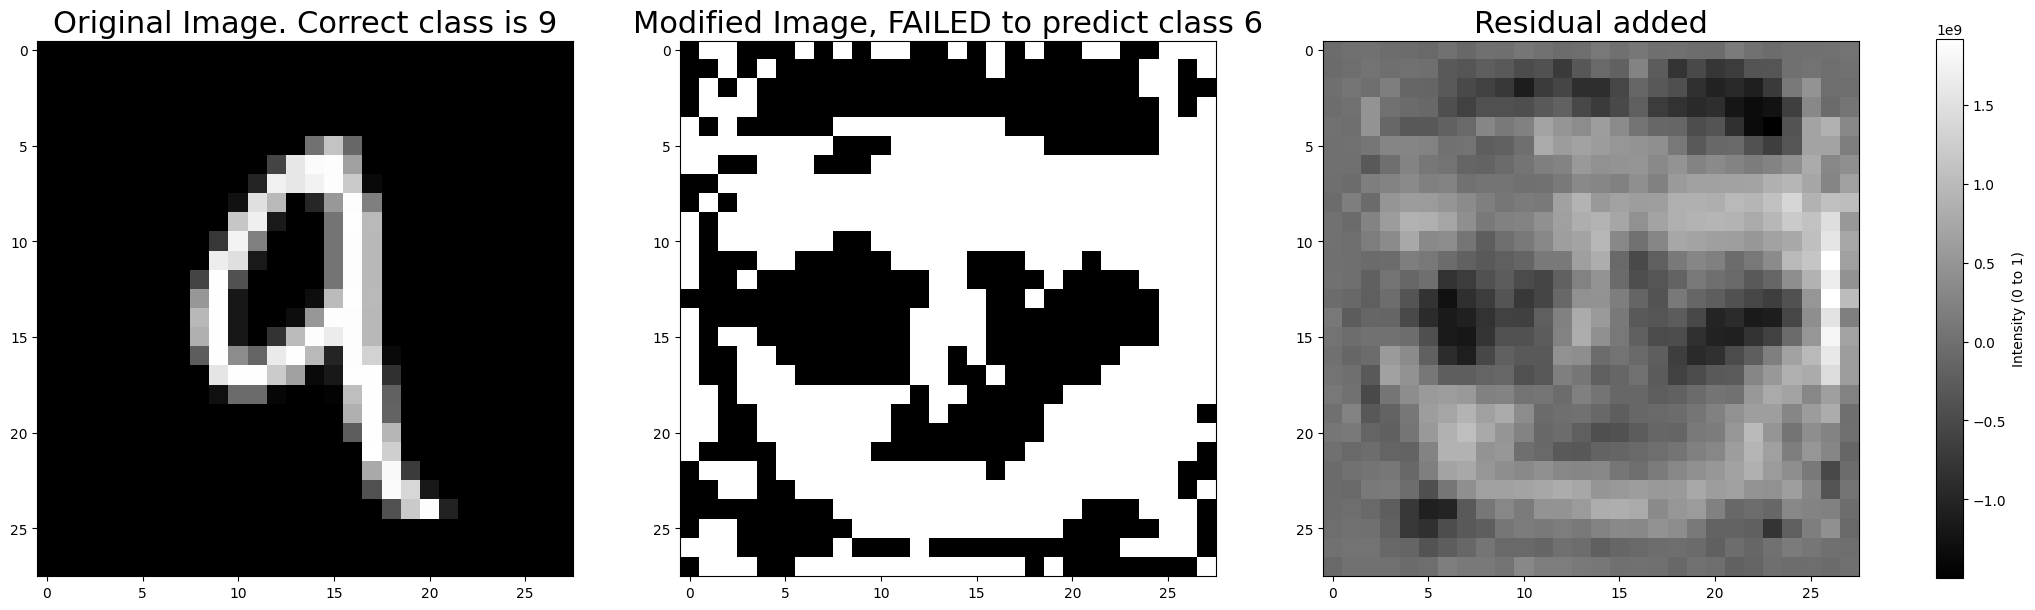


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 2 instead of tensor([6], device='cuda:0').
#######################################################
The true class is 9, the new class will be 5
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 43998248.0


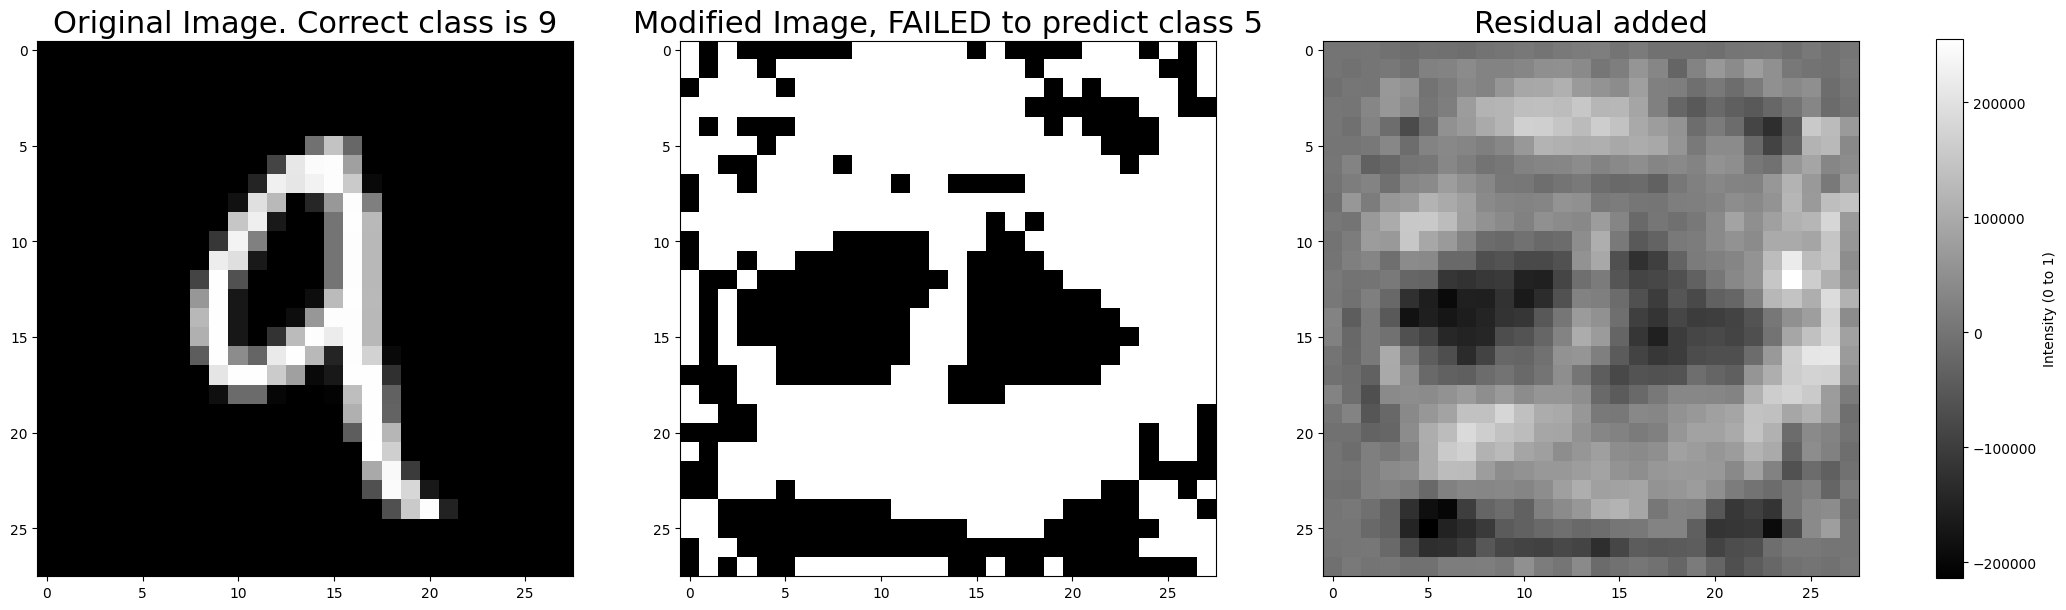


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 2 instead of tensor([5], device='cuda:0').
#######################################################
The true class is 9, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 28.676288604736328


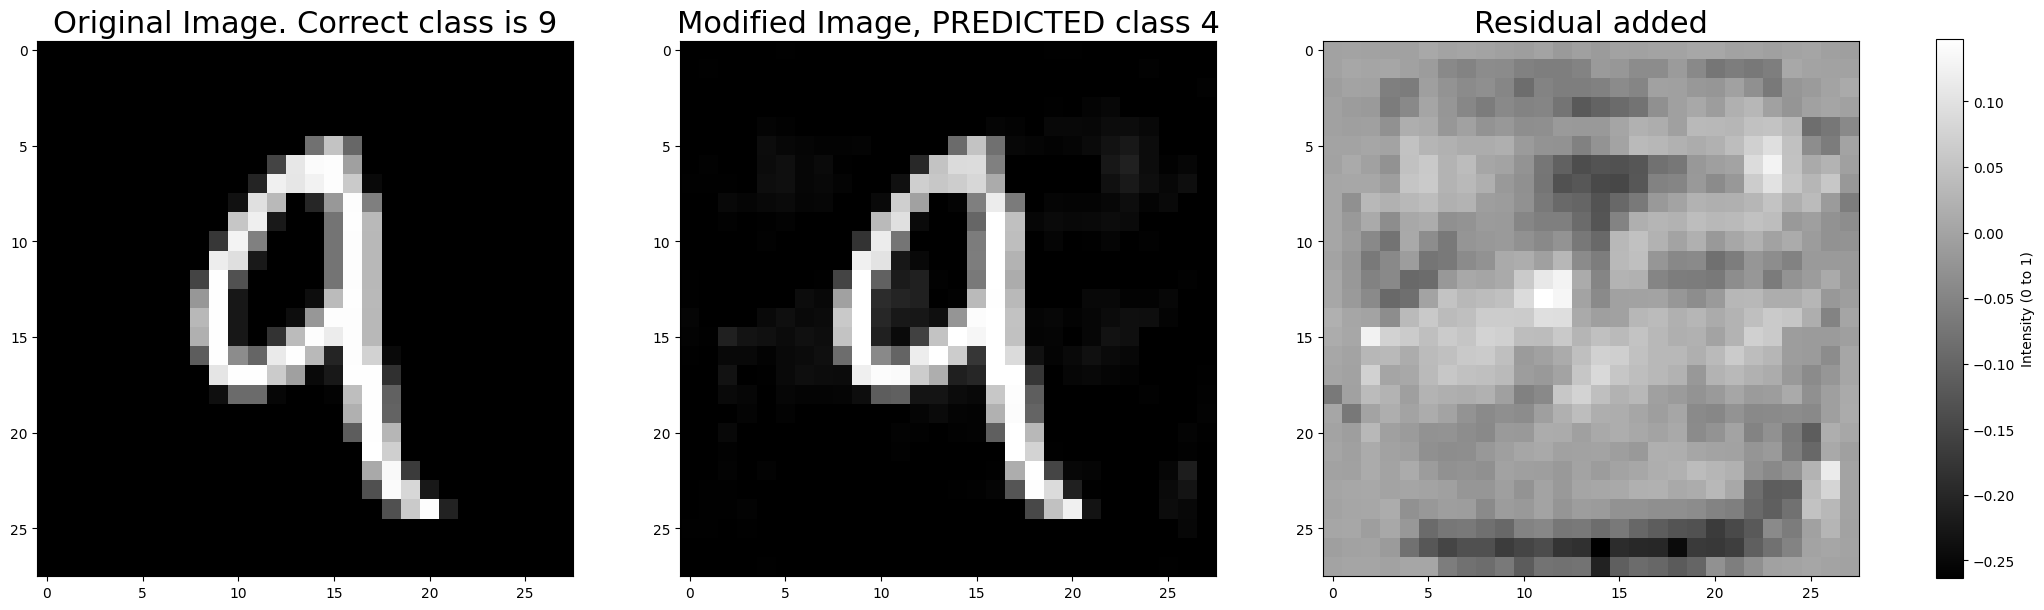


Testing adversarial example on other model...
Adversarial example correctly classified by the other model
The true class is 9, the new class will be 3
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 5041155997696.0


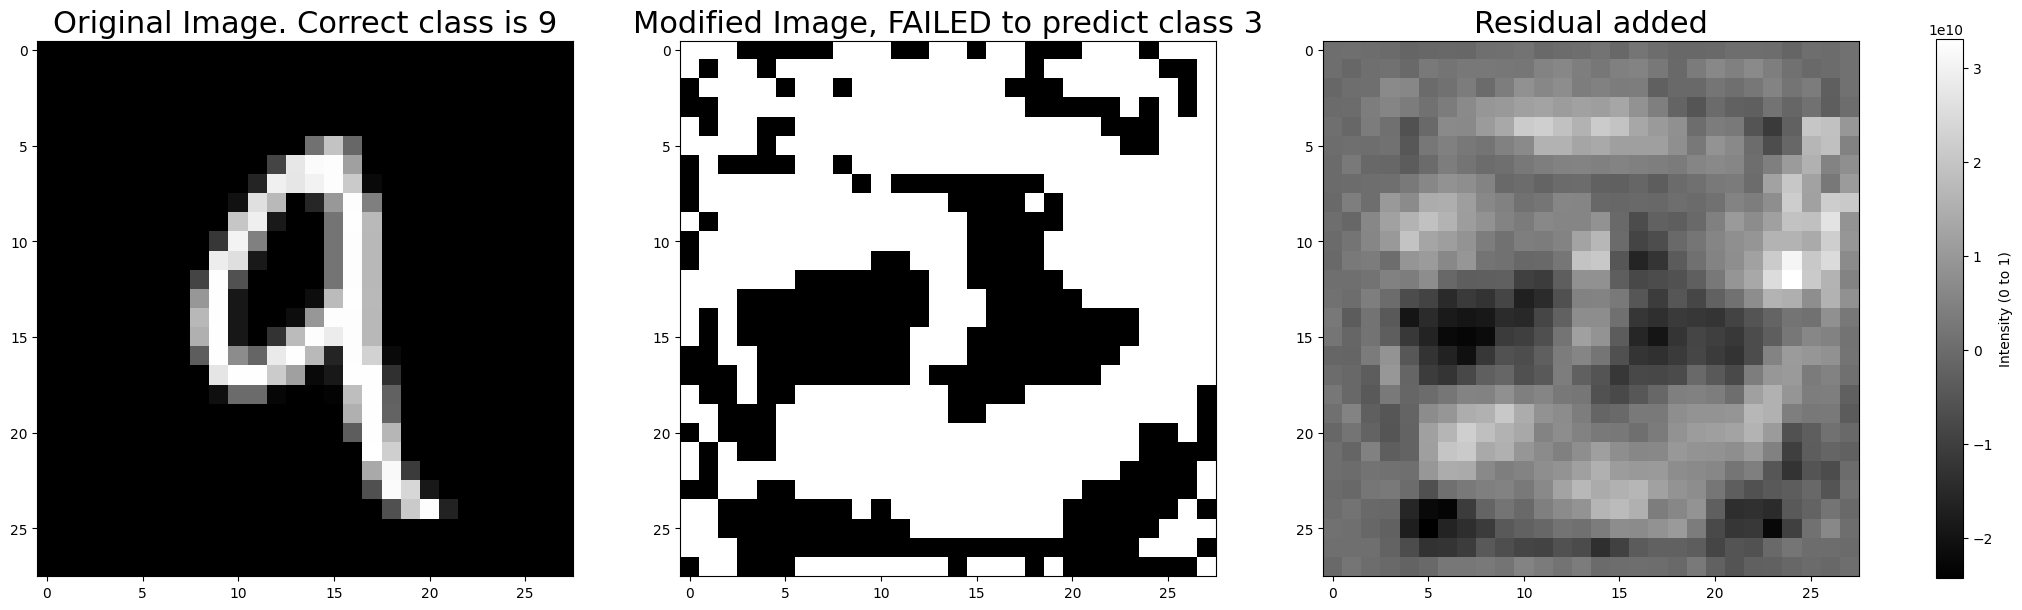


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 2 instead of tensor([3], device='cuda:0').
#######################################################
The true class is 9, the new class will be 2
Found c = 0.000011 satisfying f(x + r) = l
Optimization succeeded with c = 0.000011 in 2 iterations
Norm Perturbation |r|: 71.09107971191406


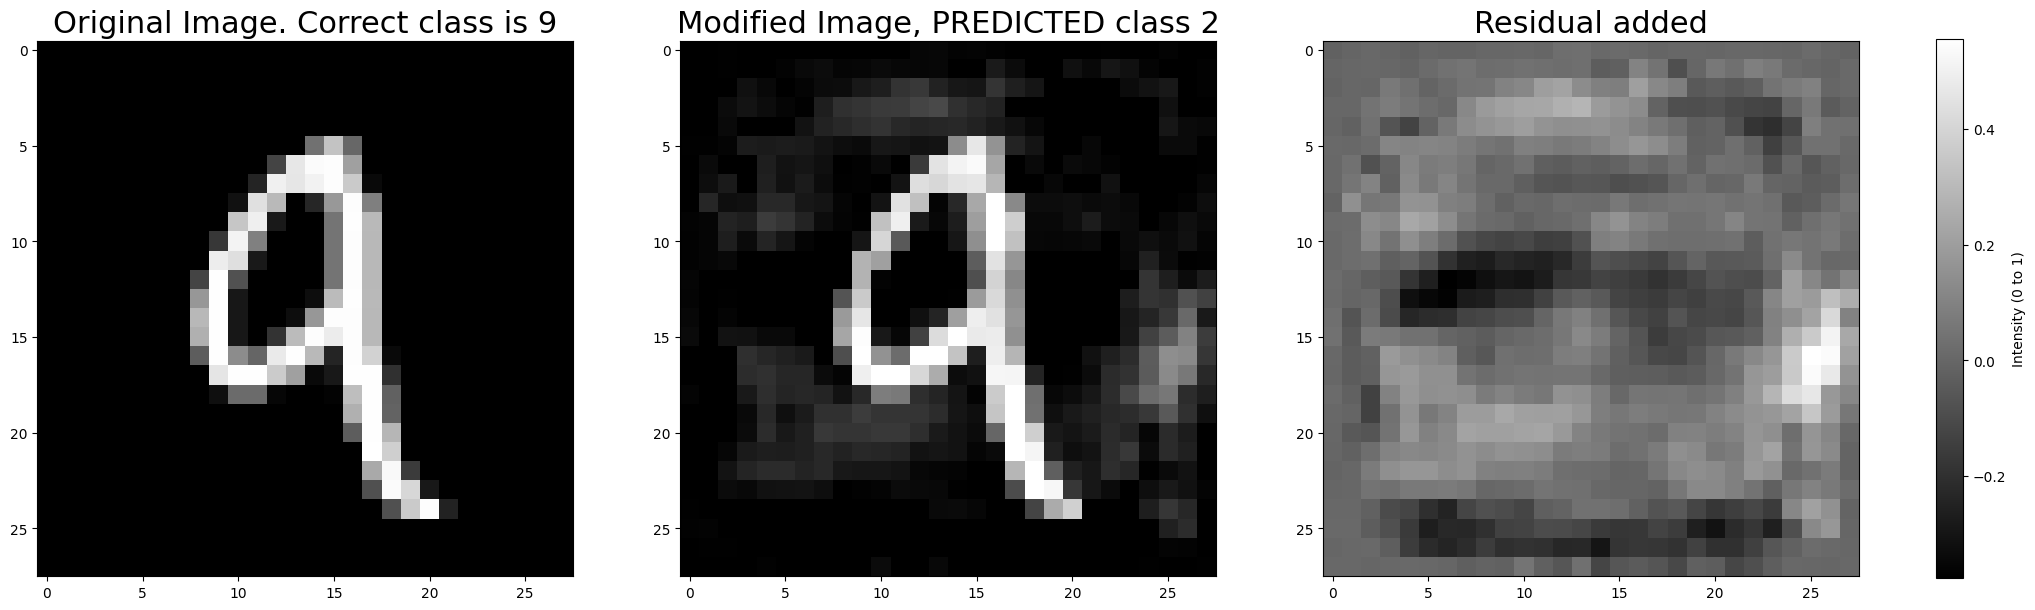


Testing adversarial example on other model...
Adversarial example correctly classified by the other model
The true class is 9, the new class will be 1
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 1305478260850688.0


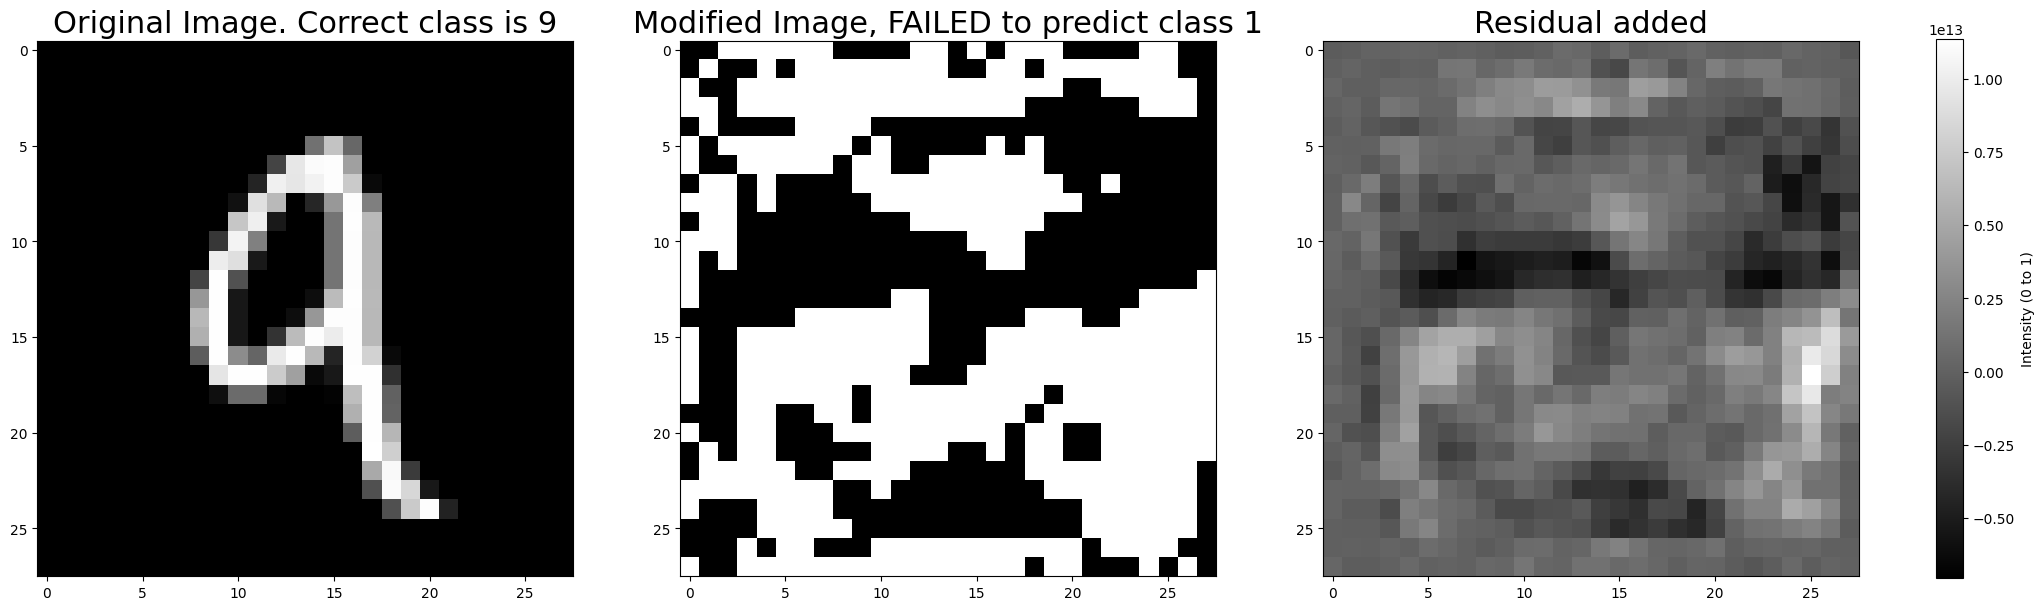


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 2 instead of tensor([1], device='cuda:0').
#######################################################
The true class is 9, the new class will be 0
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 1.7869748134121308e+18


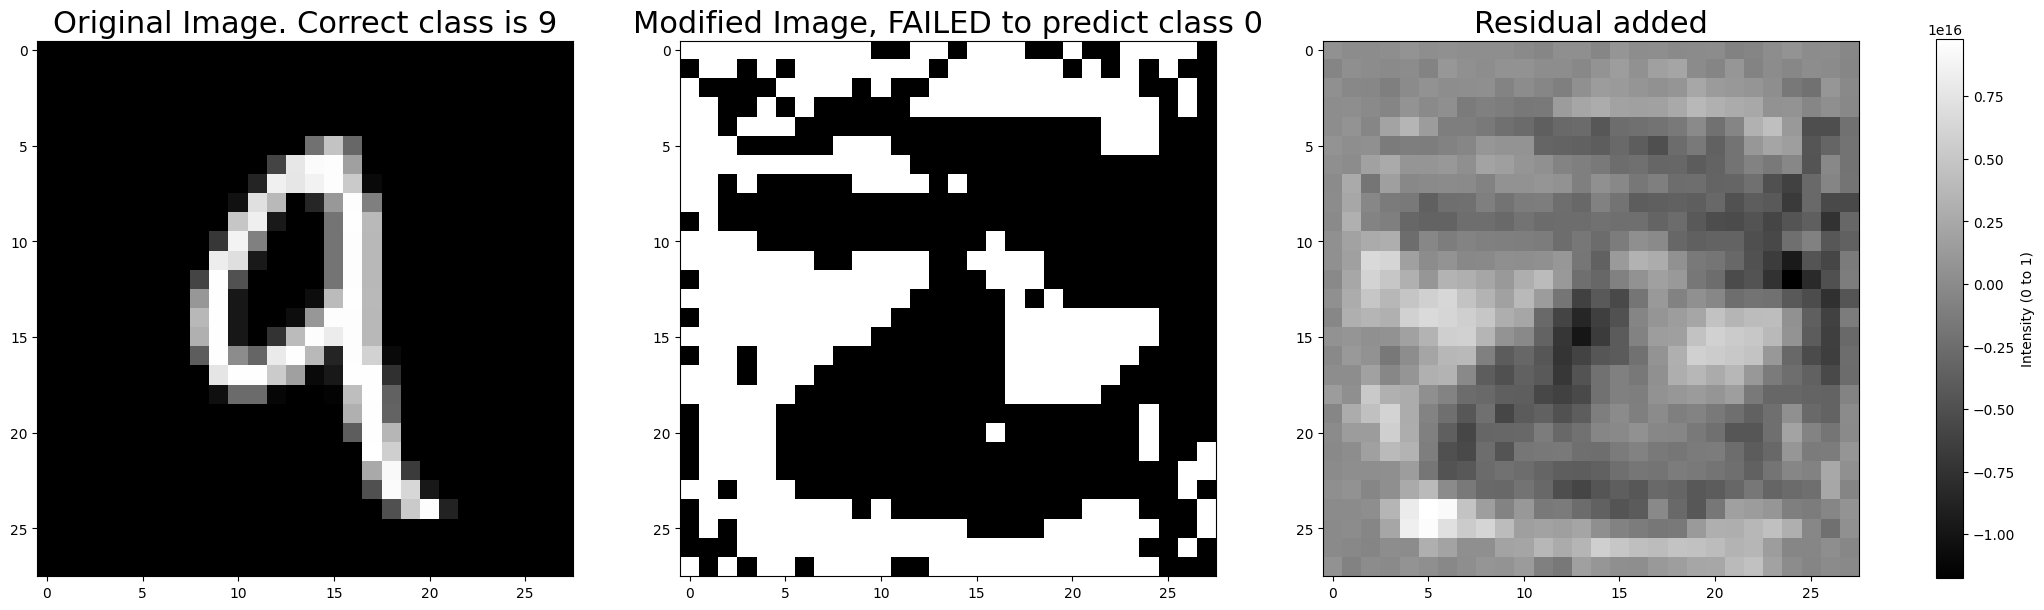


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 7 instead of tensor([0], device='cuda:0').
#######################################################


In [46]:
product_adversarial_instance(model_200, model_2_150)

## **Comments :**

When we try diffrent architecture we see that the first obsrevation about the perturbation needed to misclassifie the the image is still true, if an image is "visually" close to the adversarial target the number of itteration will be small and the norm of r too. 

We see also by comparaing cross  noticed that the result of the adverserial attack are linked between from an architecture to an other one. Othen, the adverarial attack witch work for one model work for the other one. It makes sense because this means that teh adversarials attack leverage common weaknesses in the decision boundaries of various architectures, regardless of their differences in the architecture conception.

For instance the adversial attack work for the model [200] for target 4,the other model [150,150] classify it 4 too (cf above plots)

-------
-------

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

### r and c optimized

If we optimize jointly both parameters, we have a negative c. We need to change the loss function by taking the absolute value of c

The true class is 9, the new class will be 4
Found c = 0.008932 satisfying f(x + r) = l
Optimization succeeded with c = 0.008932 in 34 iterations
Norm Perturbation |r|: 26.24706268310547


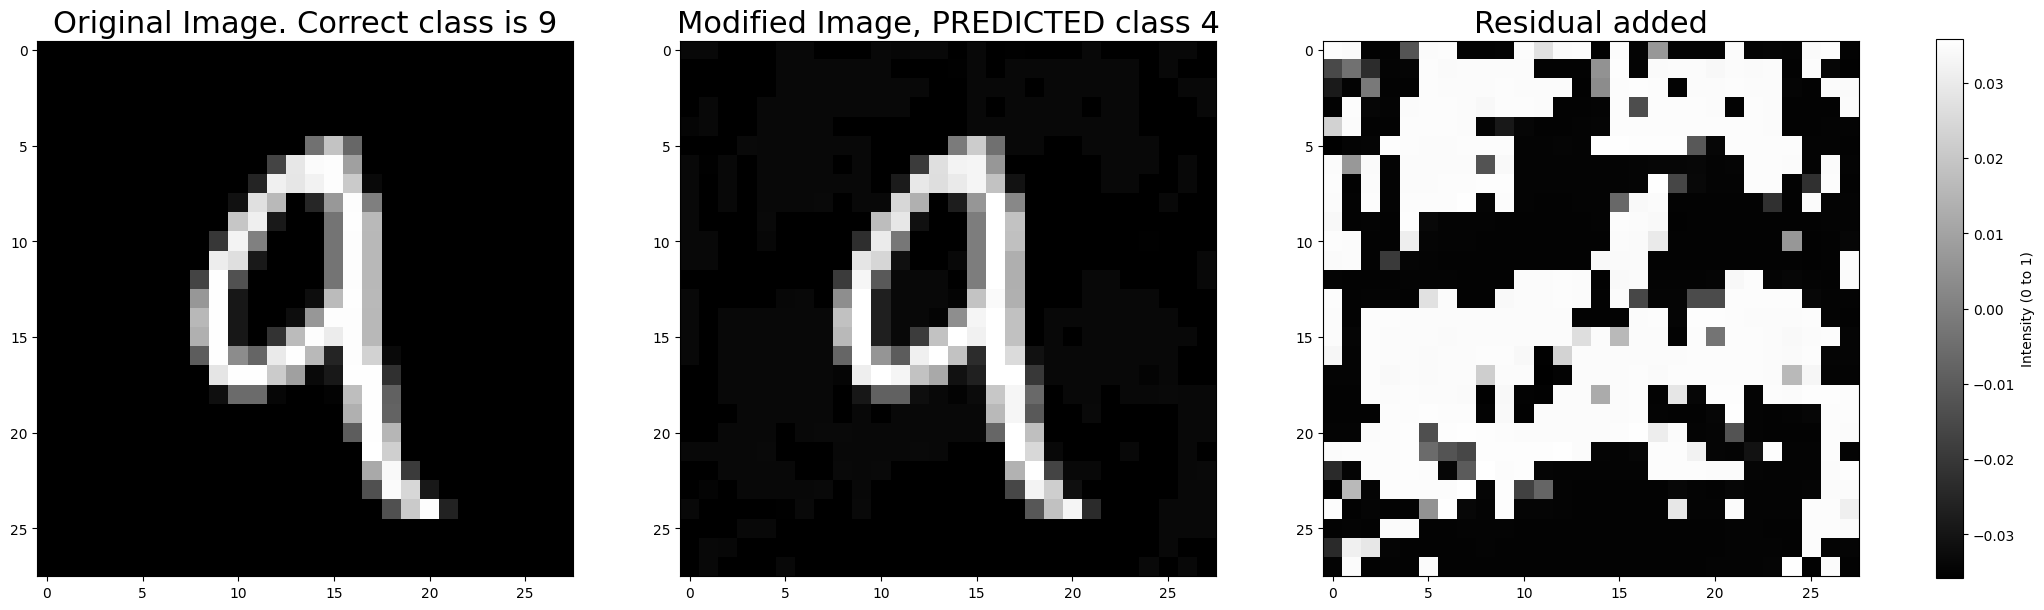

In [52]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-5 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = torch.absolute(c) * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


c = initial_c
c = torch.tensor([c]).to(device)  
c = torch.nn.Parameter(c)
iter=0

# Define the optimizer (Adam Optimizer)
optimizerAdam = optim.Adam([r, c])

while (c <= max_c) and (iter <= max_iter_search):    

    # Perform optimization
    loss = objective(c, r, testI, l) #The loss is our objective function
    loss.backward()
    optimizerAdam.step(closure)


    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1) 
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c.item():.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c.item():.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

### r optimized alone

The true class is 9, the new class will be 4
Found c = 0.005000 satisfying f(x + r) = l
Optimization succeeded with c = 0.005000 in 35 iterations
Norm Perturbation |r|: 26.253070831298828


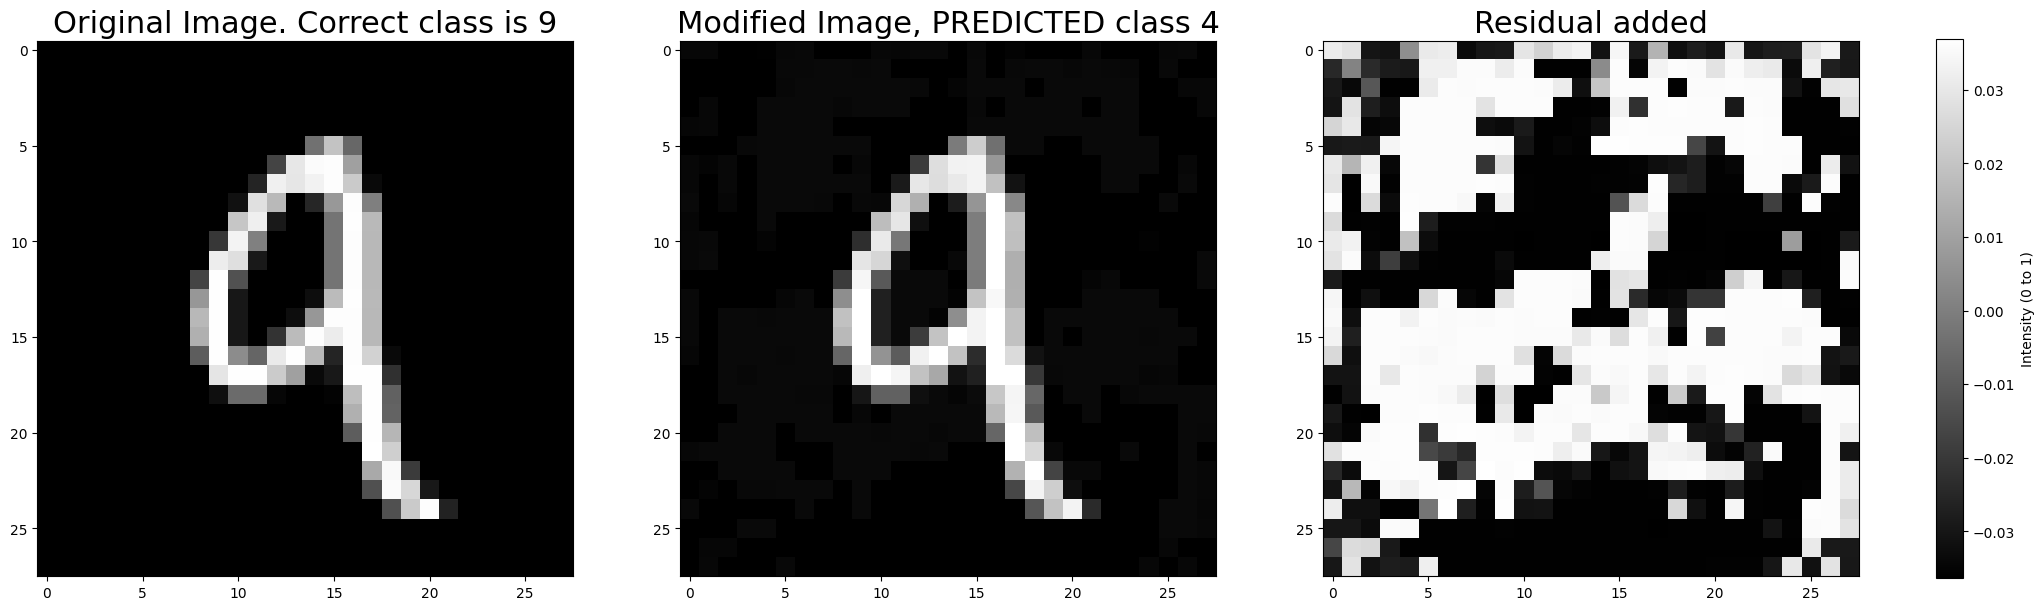

In [54]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-5 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = c * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


# Line search to find the minimum c > 0
c = 0.005
iter=0

# Define the optimizer (Adam Optimizer)
optimizerAdam = optim.Adam([r])

while (c <= max_c) and (iter <= max_iter_search):    

    # Perform optimization
    loss = objective(c, r, testI, l) #The loss is our objective function
    loss.backward()
    optimizerAdam.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1


if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

### Obersvation : 
Fixing c and using Adam to optimize r is efficient and avoids doing the all line search( so its better in terme of computationnal complexity), while the regularization term ensures that adversarial examples remain visually similar to the original image by limiting perturbations. Simultaneous estimation of c and r is less robust, as convergence is more dependent on the initial learning rate.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [82]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

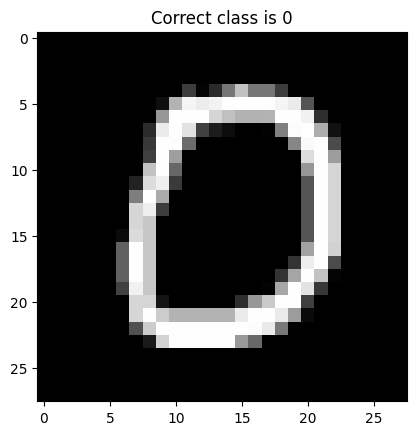

In [83]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 0
Optimization failed
Norm Perturbation |r|: 0.07840000092983246


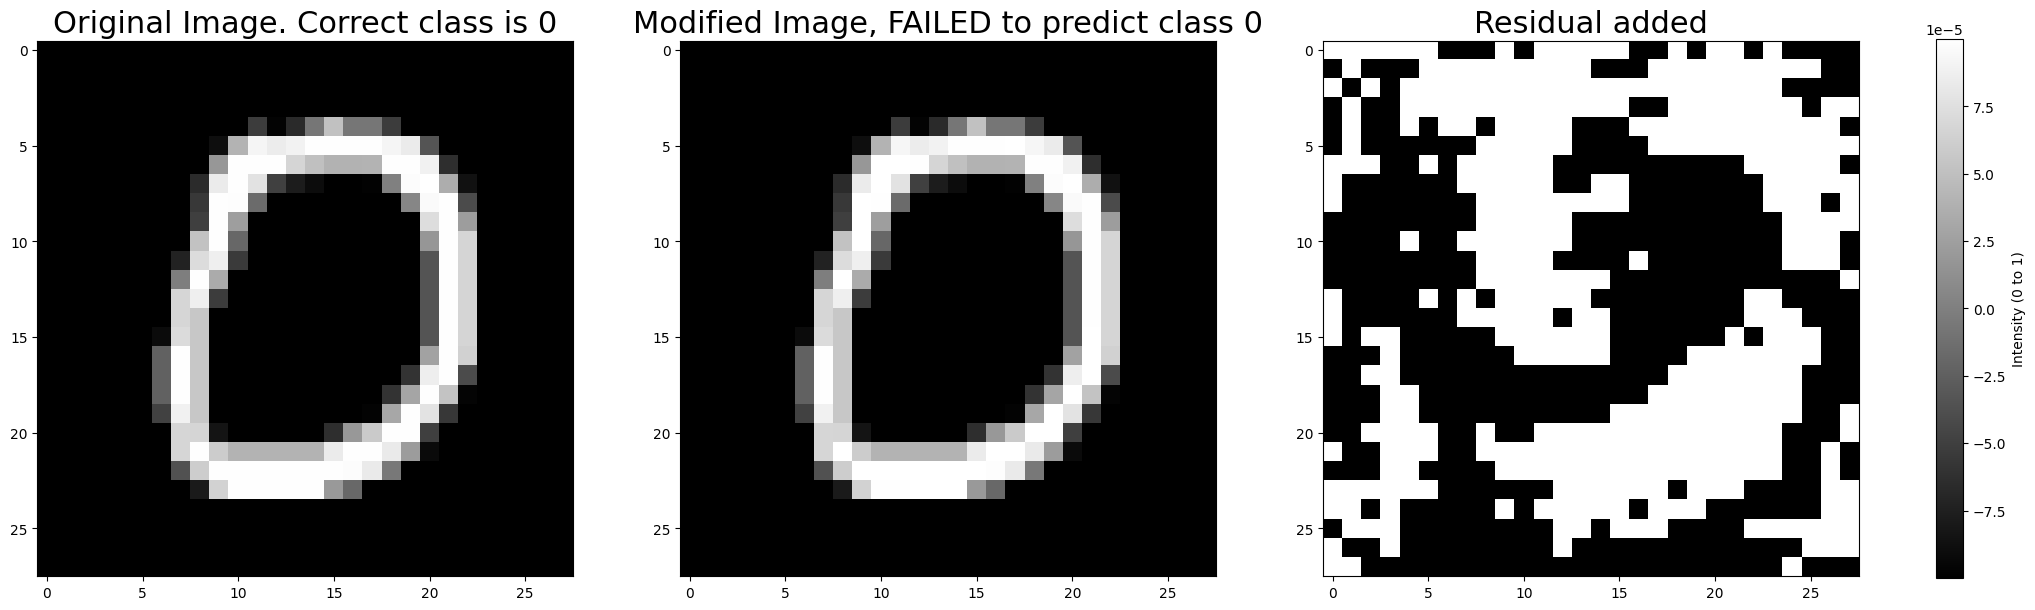

In [77]:
eps = 0.001 # perturbation size

# Forward pass of X through the model
pred_original = model(X) 
original_class = torch.tensor([testY]).to(device)  
original_class=original_class.to(device)
original_class = original_class.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss 

# Compute loss
cost = loss_model(pred_original, original_class)

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps*X.grad.data.sign()

# Re-classify the perturbed image
perturbed_class = torch.argmax(model(Xr))   

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)   
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Using epsilon: 0.01 we succesfully create 0.0741 % adversariale examples


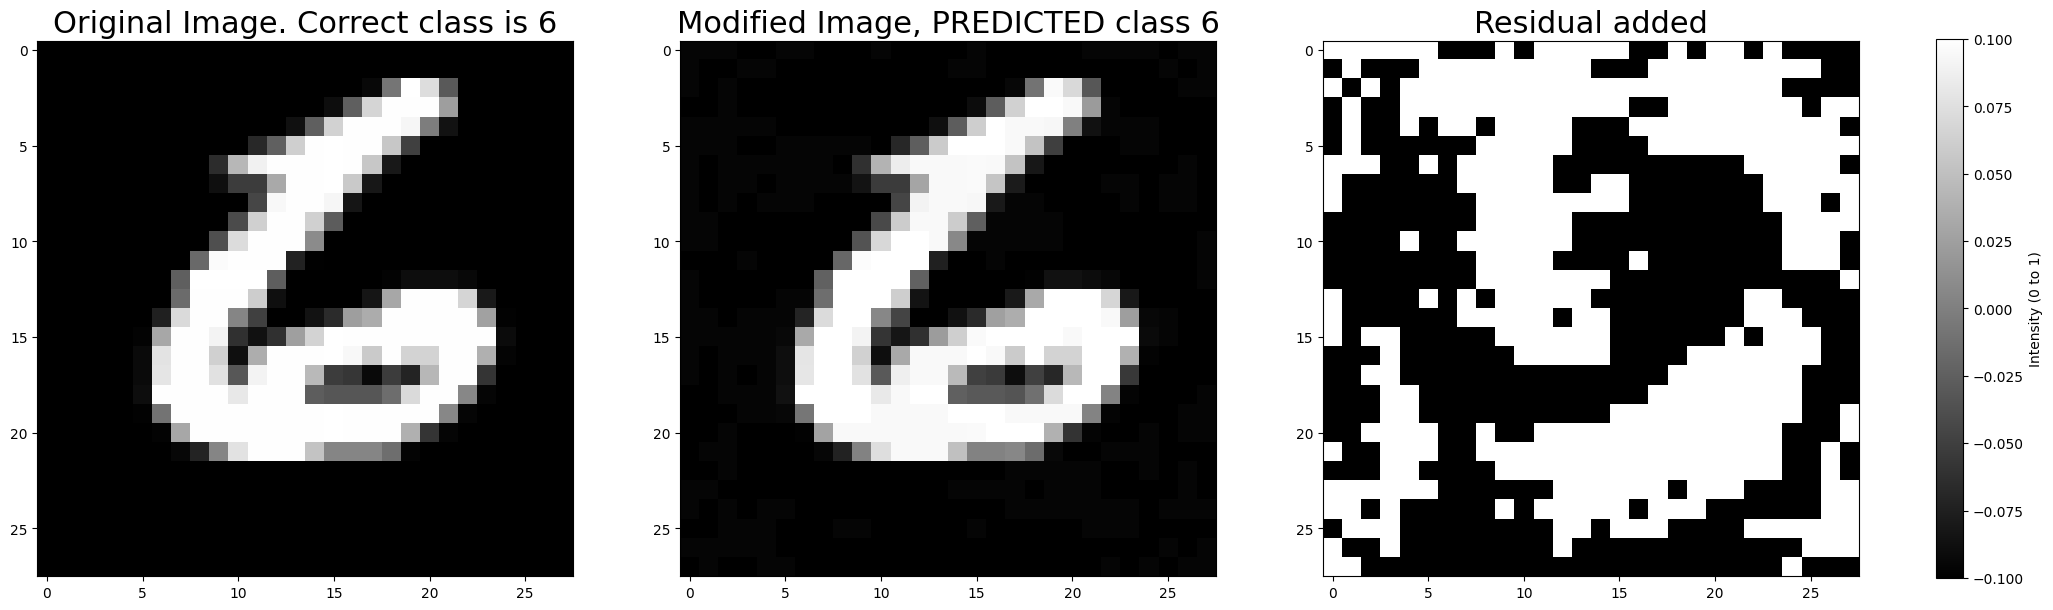

Using epsilon: 0.1 we succesfully create 0.50115 % adversariale examples


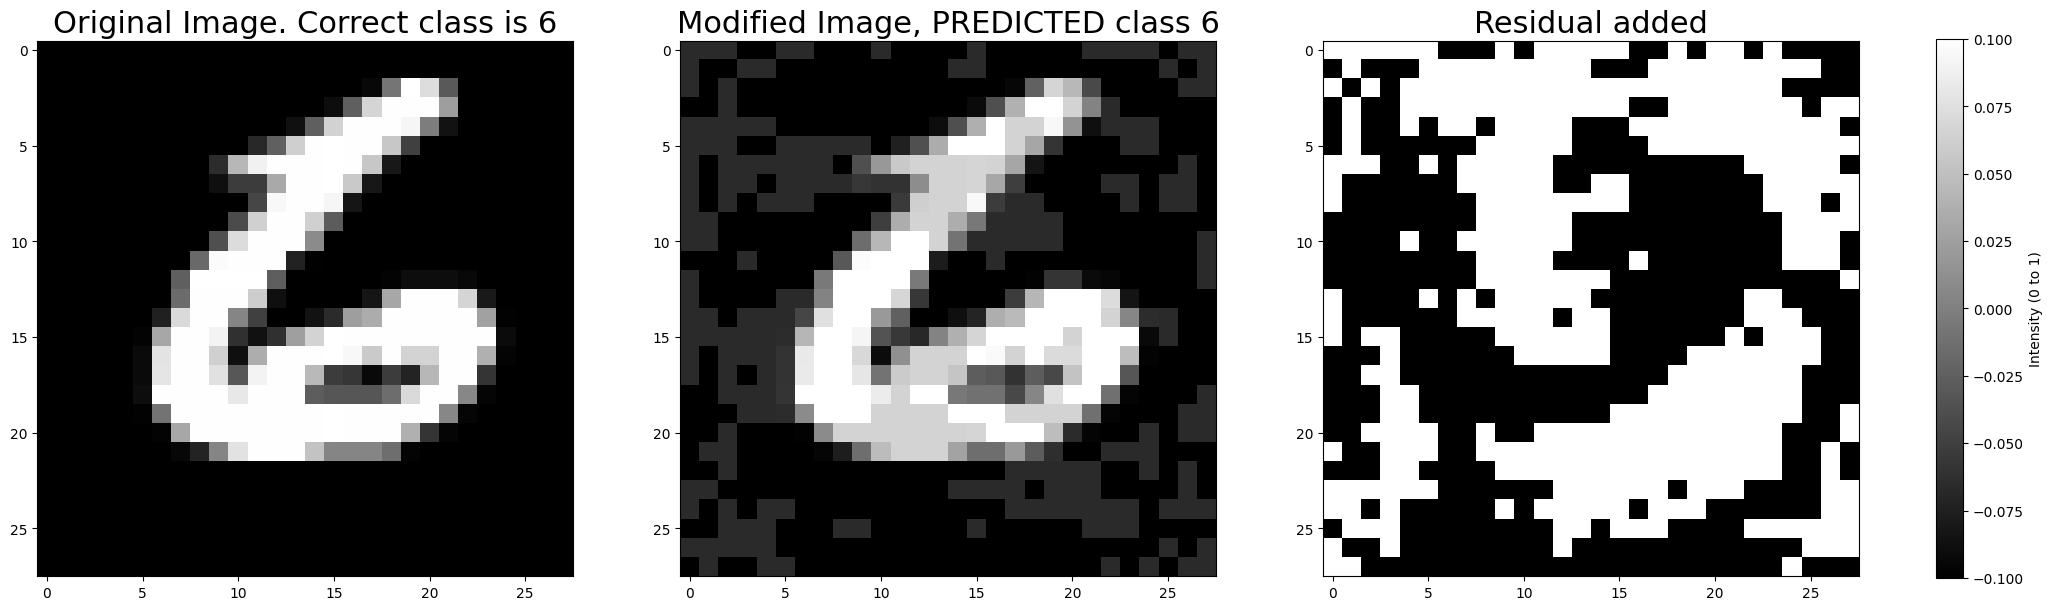

Using epsilon: 0.15 we succesfully create 0.6625 % adversariale examples


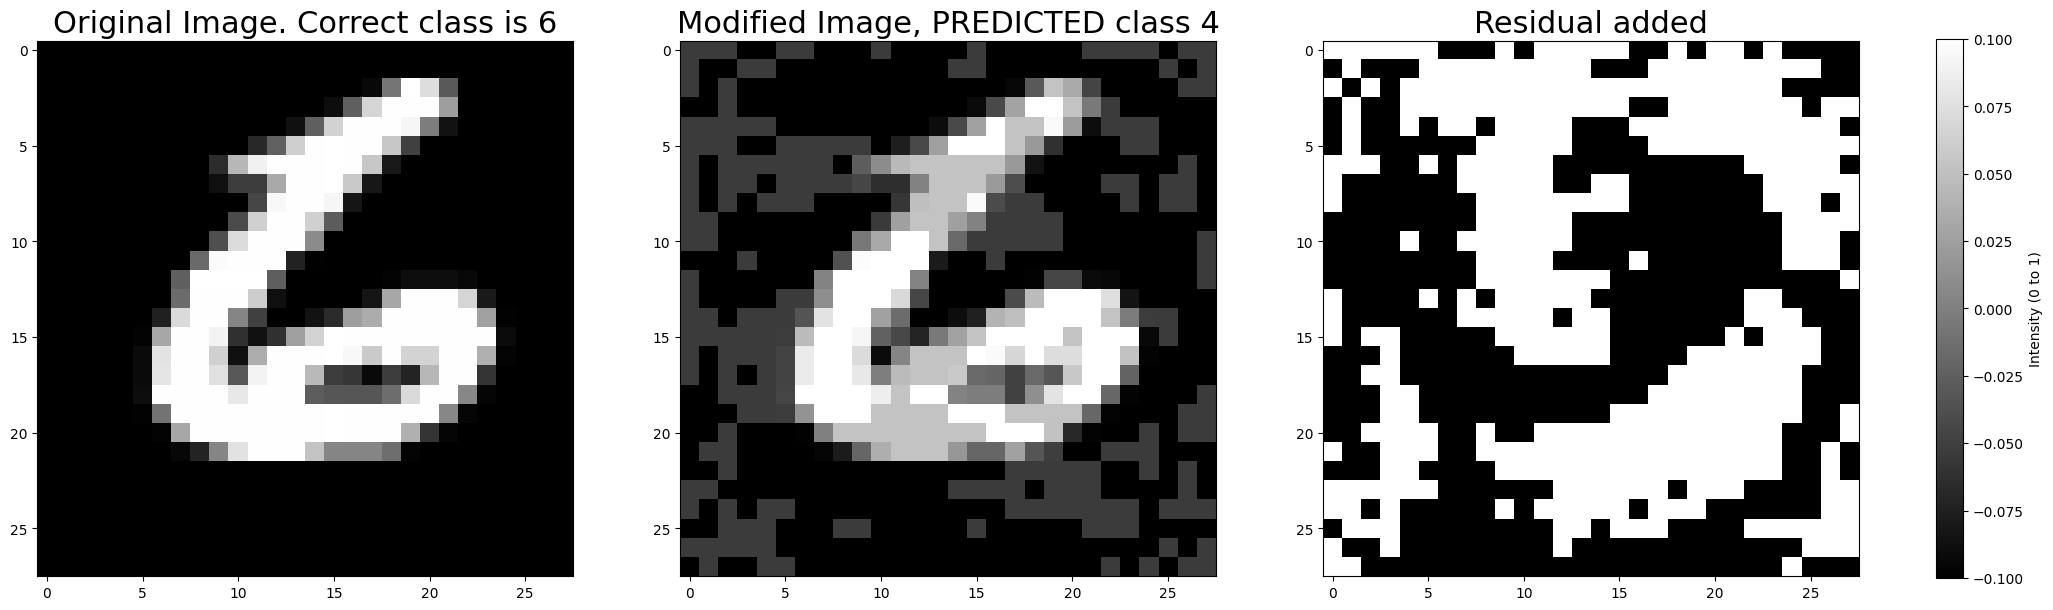

Using epsilon: 0.2 we succesfully create 0.7458 % adversariale examples


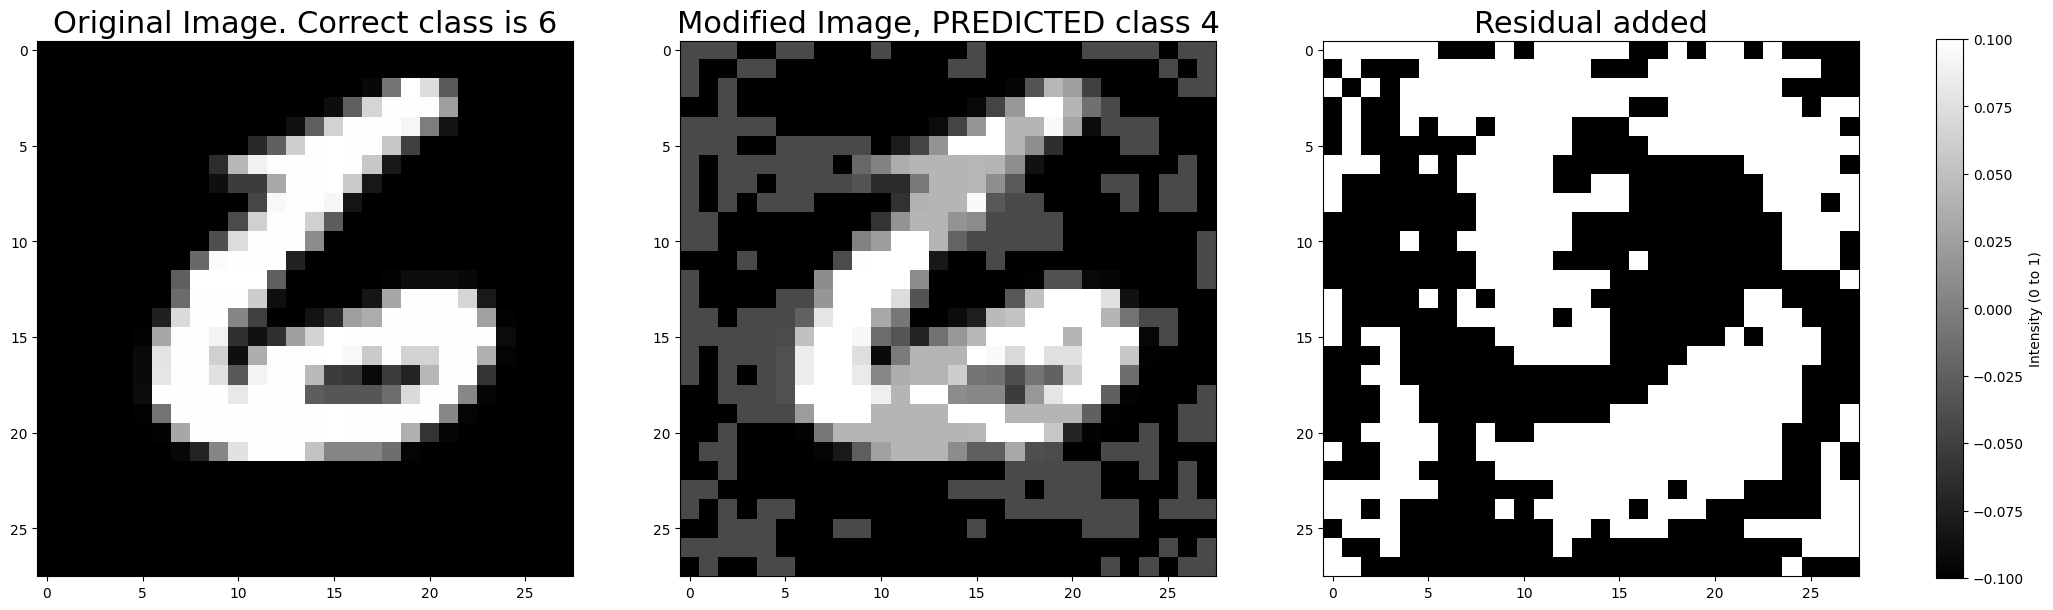

Using epsilon: 0.25 we succesfully create 0.79618 % adversariale examples


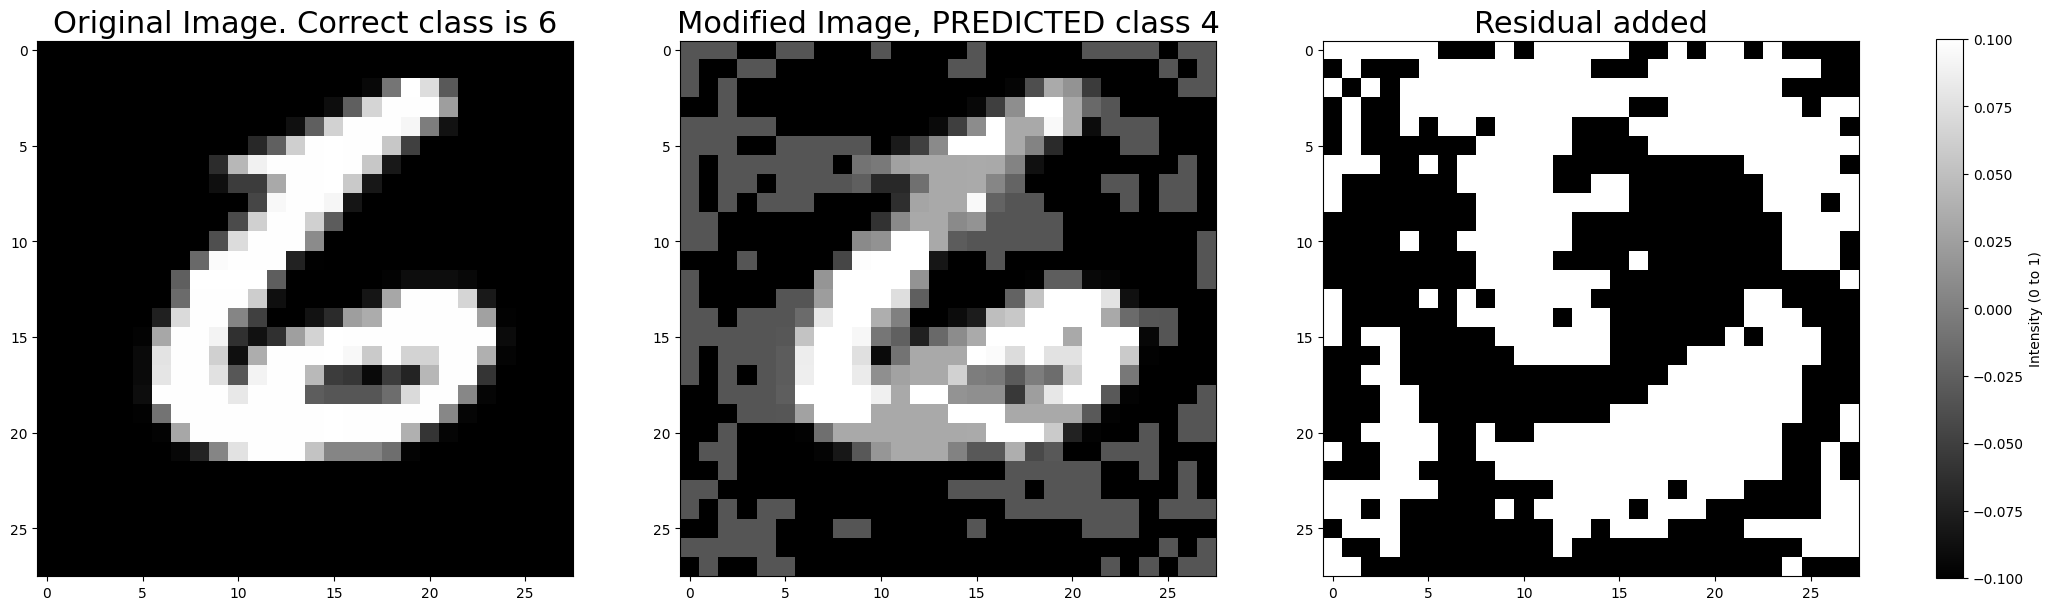

Using epsilon: 0.3 we succesfully create 0.82995 % adversariale examples


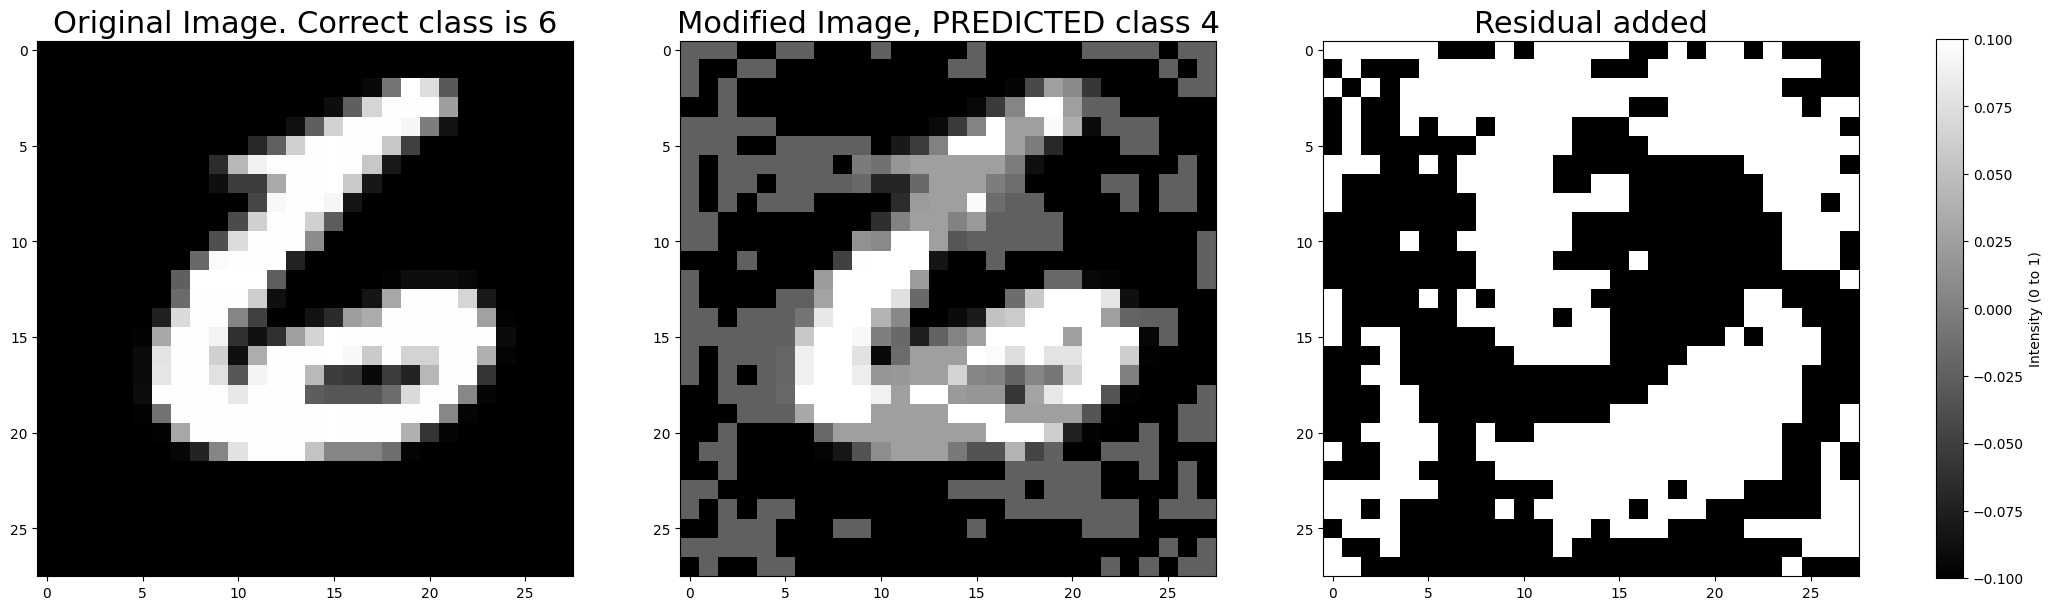

Using epsilon: 0.4 we succesfully create 0.8541428571428571 % adversariale examples


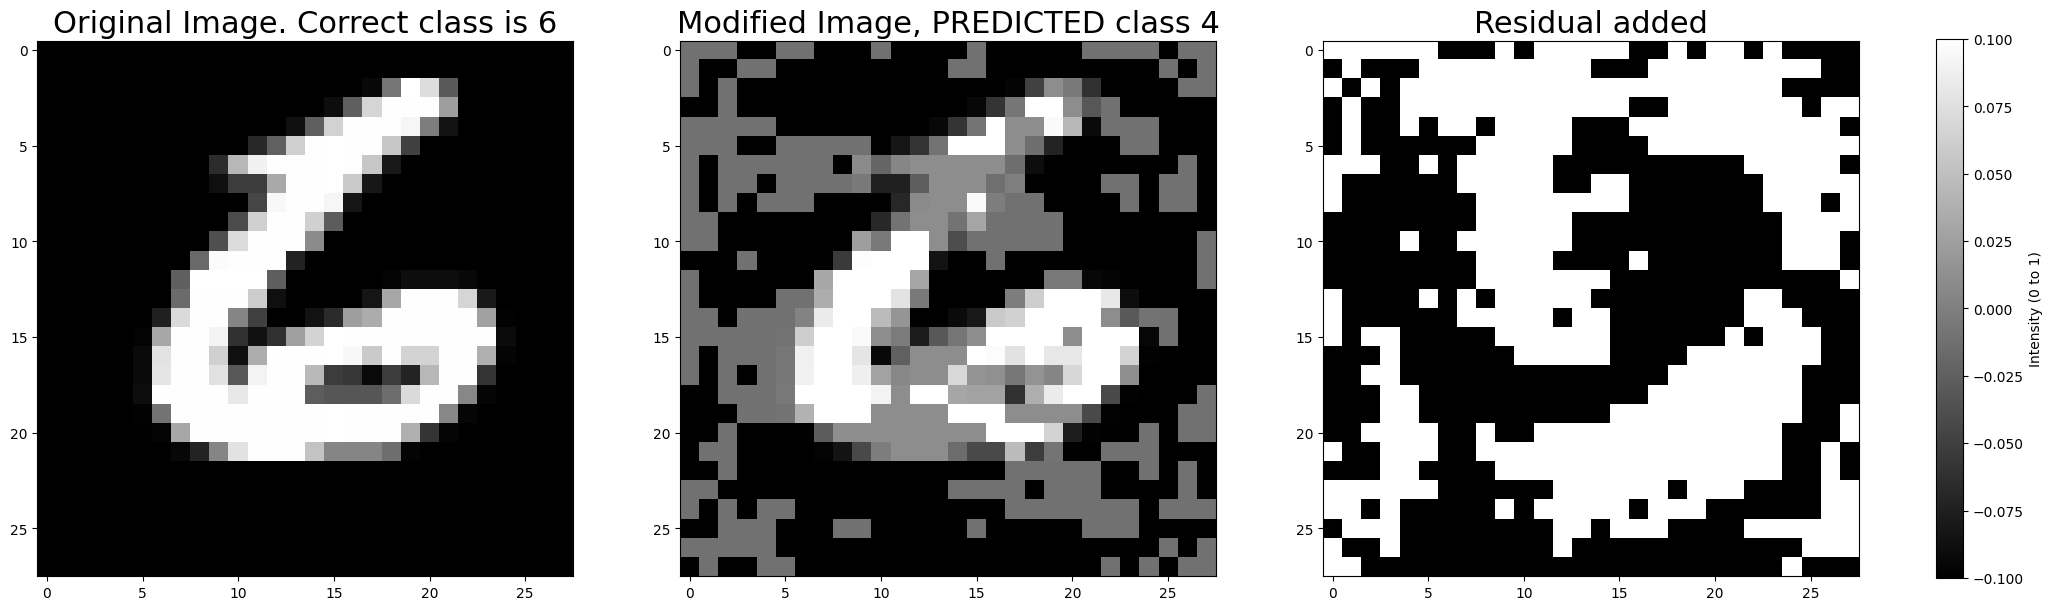

In [98]:
def fgsm_attack(X, Y, model, loss_model, eps):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = X.to(device), Y.to(device) 
    model = model.to(device)
    loss_model = loss_model.to(device) 
 

    model.zero_grad()

    X.requires_grad = True #In order to compute a gradient of the image

    original_class = torch.tensor([Y]).to(device)  
    original_class = original_class.view(1).to(device) 
    
    # Compute loss
    cost = loss_model(model(X), original_class)

    # Compute gradients
    cost.backward()

    # FGSM attack code
    Xr = X + eps*X.grad.data.sign()

    # Re-classify the perturbed image
    perturbed_class = torch.argmax(model(Xr))    

    return Xr, original_class, perturbed_class, r

# Accuracy counter
adv_examples = []
succes=0
list_eps = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
list_acc = []

for eps in list_eps : 

    # Loop over all examples in test set
    for X_batch, Y_batch in test_loader:  # Iterate through batches
        for X, Y in zip(X_batch, Y_batch):
            
            Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)
            adv_examples.append(Xr)

            if perturbed_class.item() != Y.item() :
                succes = succes + 1

    # Calculate final accuracy for this epsilon
    Adv_acc = succes/len(adv_examples)
    list_acc.append(Adv_acc)
    print(f"Using epsilon: {eps} we succesfully create {Adv_acc} % adversariale examples")   

    # Plot one example
    index=0
    #plot_results(adv_examples[6]) doesn't work with one image only
    plot_results(X, r, Xr, Y, perturbed_class, fail=False)


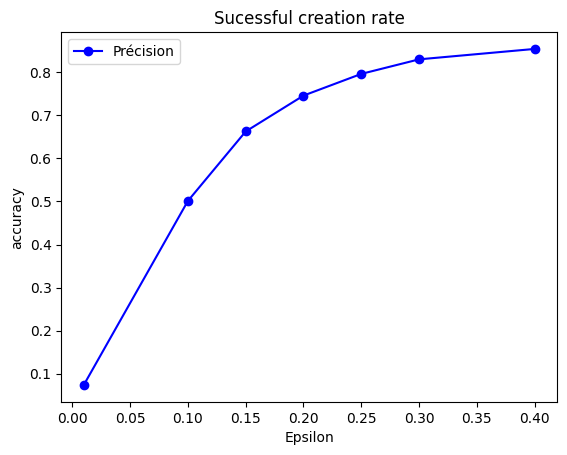

In [100]:
plt.plot(list_eps, list_acc, marker='o', color='b', linestyle='-', label='Précision')

plt.title('Sucessful creation rate')
plt.xlabel('Epsilon')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Obsrevation : 

The higher the epsilon, the better is the succesful rate, but there is a counterpart in the visual appearance of the generated image. The higher the epsilon, the more degraded the image. An espilon value equal to 2 seems to be a good compromise. 